In [1]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass


import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # tensorflow INFO and WARNING messages are not printed

In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image, ImageOps
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import cv2

In [3]:
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/flower_photos.tgz"
data_dir = keras.utils.get_file(origin=dataset_url,
                                fname='flower_photos',
                                untar=True)

data_dir = pathlib.Path(data_dir)

for folder in data_dir.glob('[!LICENSE]*'):
    print('The', folder.name, 'folder has',
          len(list(folder.glob('*.jpg'))), 'pictures')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count, 'total images')

228813984/228813984 [==============================] - 7s 0us/step
The tulips folder has 799 pictures
The roses folder has 641 pictures
The daisy folder has 633 pictures
The sunflowers folder has 699 pictures
The dandelion folder has 898 pictures
3670 total images


Let's extract some images we can use for this lab. We will set them all to be square images of 300x300, and display them as well.

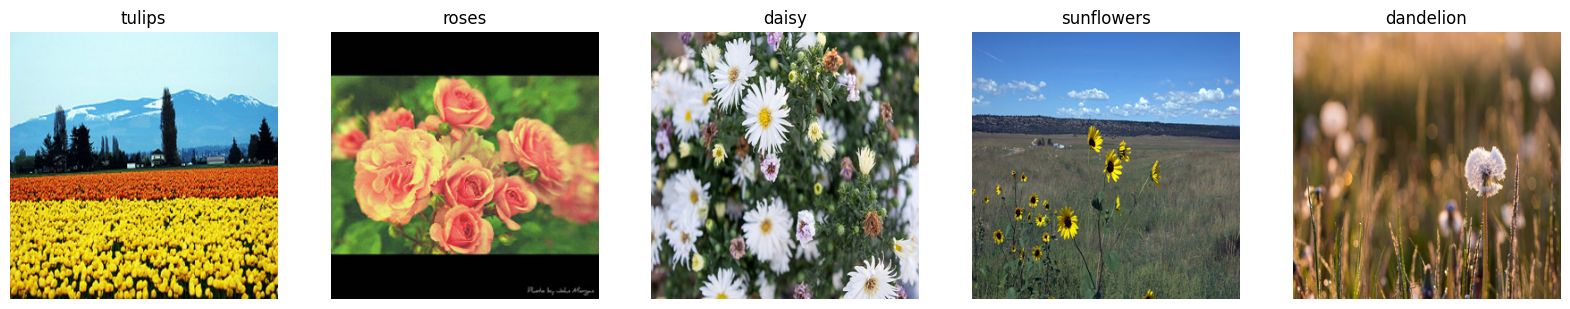

In [4]:
pics = list()
pics_arr = list()
p_class = list()

img_width = 300
img_height = 300

plt.figure(figsize=(20,5))
for idx, folder in enumerate(data_dir.glob('[!LICENSE]*')):
    cat = list(data_dir.glob(folder.name + '/*'))
    pic = PIL.Image.open(str(cat[0])).resize((img_width, img_height))
    pic_arr = np.array(pic)
    clss = folder.name

    plt.subplot(1,5,idx+1)
    plt.imshow(pic)
    plt.title(clss)
    plt.axis('off')

    pics.append(pic)
    pics_arr.append(pic_arr)
    p_class.append(clss)


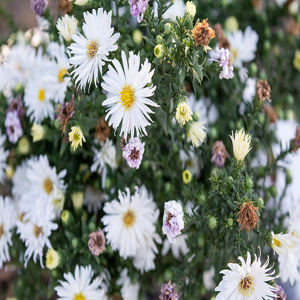

In [5]:
# Lets get an image to use for the rest of the exercises
img = pics[2]
img

# Exercise 1: Implementing Edge Detection

In [6]:
# Lets define our custom kernels for the horizontal and vertical gradients
def v_grad(shape, dtype=None):
    # Here we use a single numpy array to define our x gradient kernel
    grad = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1]
    ]).reshape((3, 3, 1, 1))
    # this line is quite important, we are saying we want one 3x3 kernel each for one channel of pixels (grayscale)

    # We check to make sure the shape of our kernel is the correct shape
    # according to the initialization of the Convolutional layer below
    assert grad.shape == shape
    return keras.backend.variable(grad, dtype='float32')

def h_grad(shape, dtype=None):
    grad = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
        ]).reshape((3, 3, 1, 1))

    assert grad.shape == shape
    return keras.backend.variable(grad, dtype='float32')

Building the Convolutional Neural Network
Here we will build two very simple one layer convolutional neural networks, which will just apply our kernels over an input image. The definition of the function is below.

keras.layers.Conv2d

keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)

In [7]:
# We define the input layer of our Neural Network
# to take in an image of 300x300 with 1 channel
# Both our models can share this, as it will not change between the two

input_layer = layers.Input(shape=(img_width, img_height, 1))

h_conv = layers.Conv2D(filters=1, # the number of kernels we are using, kernel and filter are interchangeable terms
                       kernel_size=3,
                       kernel_initializer=h_grad,
                       strides=1,
                       padding='valid')  # 'valid' means no padding

v_conv = layers.Conv2D(filters=1,
                       kernel_size=3,
                       kernel_initializer=v_grad,
                       strides=1,
                       padding='valid')


h_model = keras.Sequential([input_layer, h_conv])
v_model = keras.Sequential([input_layer, v_conv])

In [8]:
h_model.summary()
v_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 1)       10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 298, 298, 1)       10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [10]:
gray = ImageOps.grayscale(img)

# We need to add 1 dimension to our input image which represents the batch size
# In this case, we just want to process 1 image.
input_img = np.array(gray).reshape((1, img_width, img_height, 1))

out_d = h_model.layers[0].output_shape[1:]

# Pass our input image into each model, and return
# the output with a shape of (298,298,1) in variables named `Gy` and `Gx`.

Gx = h_model.predict(input_img).reshape(out_d)
Gy = v_model.predict(input_img).reshape(out_d)

1/1 [==============================] - 0s 74ms/step


In [11]:
G = np.sqrt(np.add(np.multiply(Gx, Gx), np.multiply(Gy, Gy)))

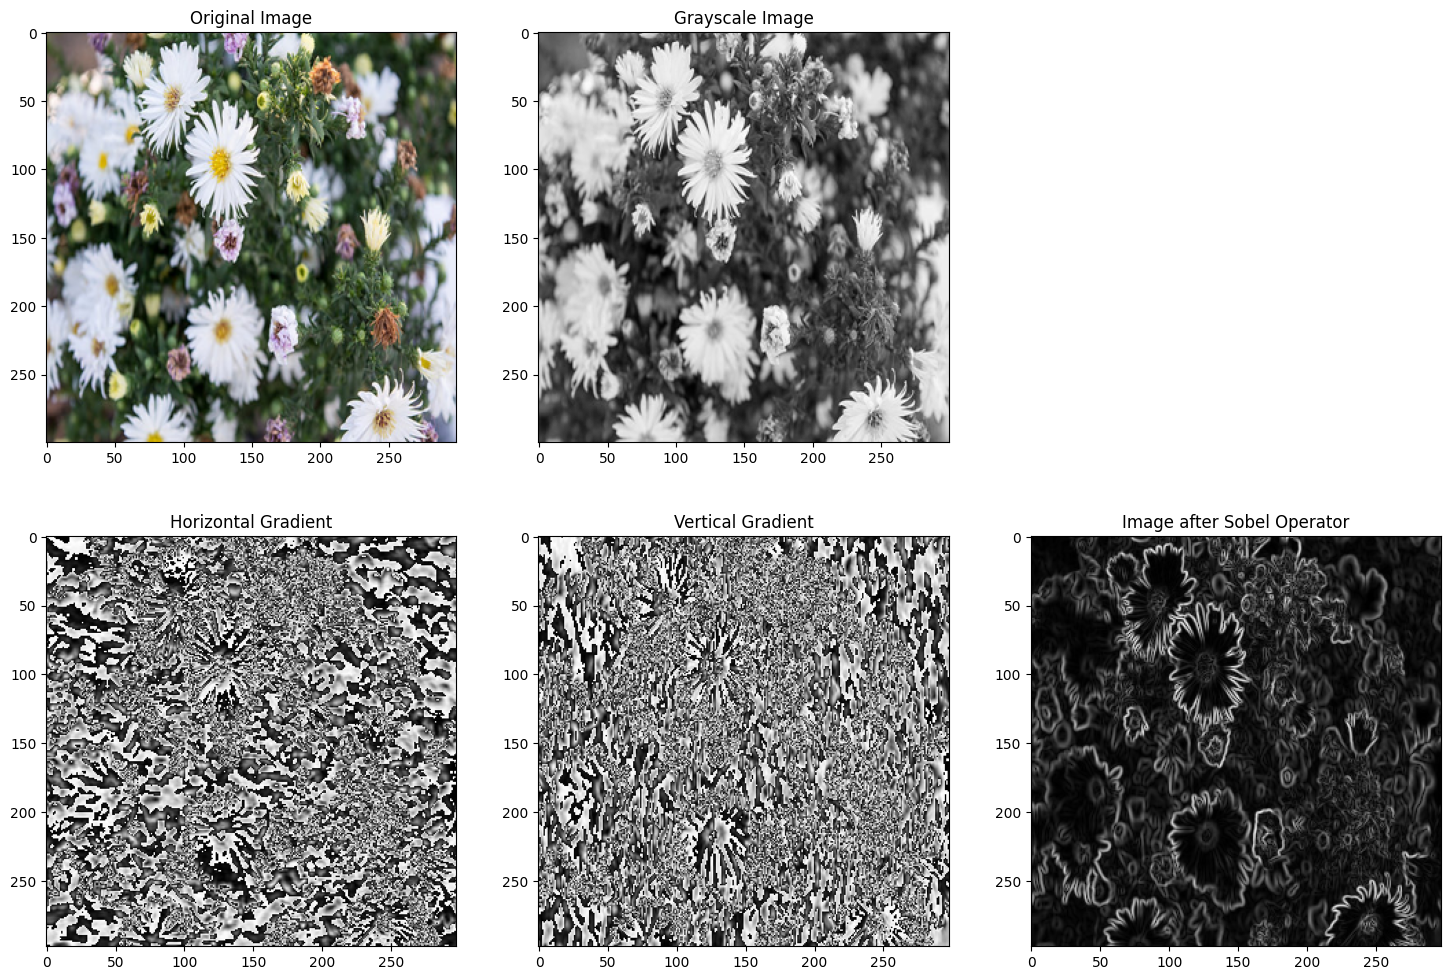

In [12]:
plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 3, 2)
plt.imshow(gray, cmap=plt.get_cmap('gray'))
plt.title("Grayscale Image")
plt.subplot(2, 3, 4)
plt.imshow(Gx.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Horizontal Gradient")
plt.subplot(2, 3, 5)
plt.imshow(Gy.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Vertical Gradient")
plt.subplot(2, 3, 6)
plt.imshow(G, cmap=plt.get_cmap('gray'))
plt.title("Image after Sobel Operator")
plt.show()

# Difference Of Gaussian (DoG)
This is a method for both corner and blob detection. The way it works is by convolving two Gaussian kernels with different variances (sigma) over an image which will produce two blurred versions of the input image. We then subtract the two blurred images and get the resulting DoG processed image which should make it easy to identify corners and blobs.



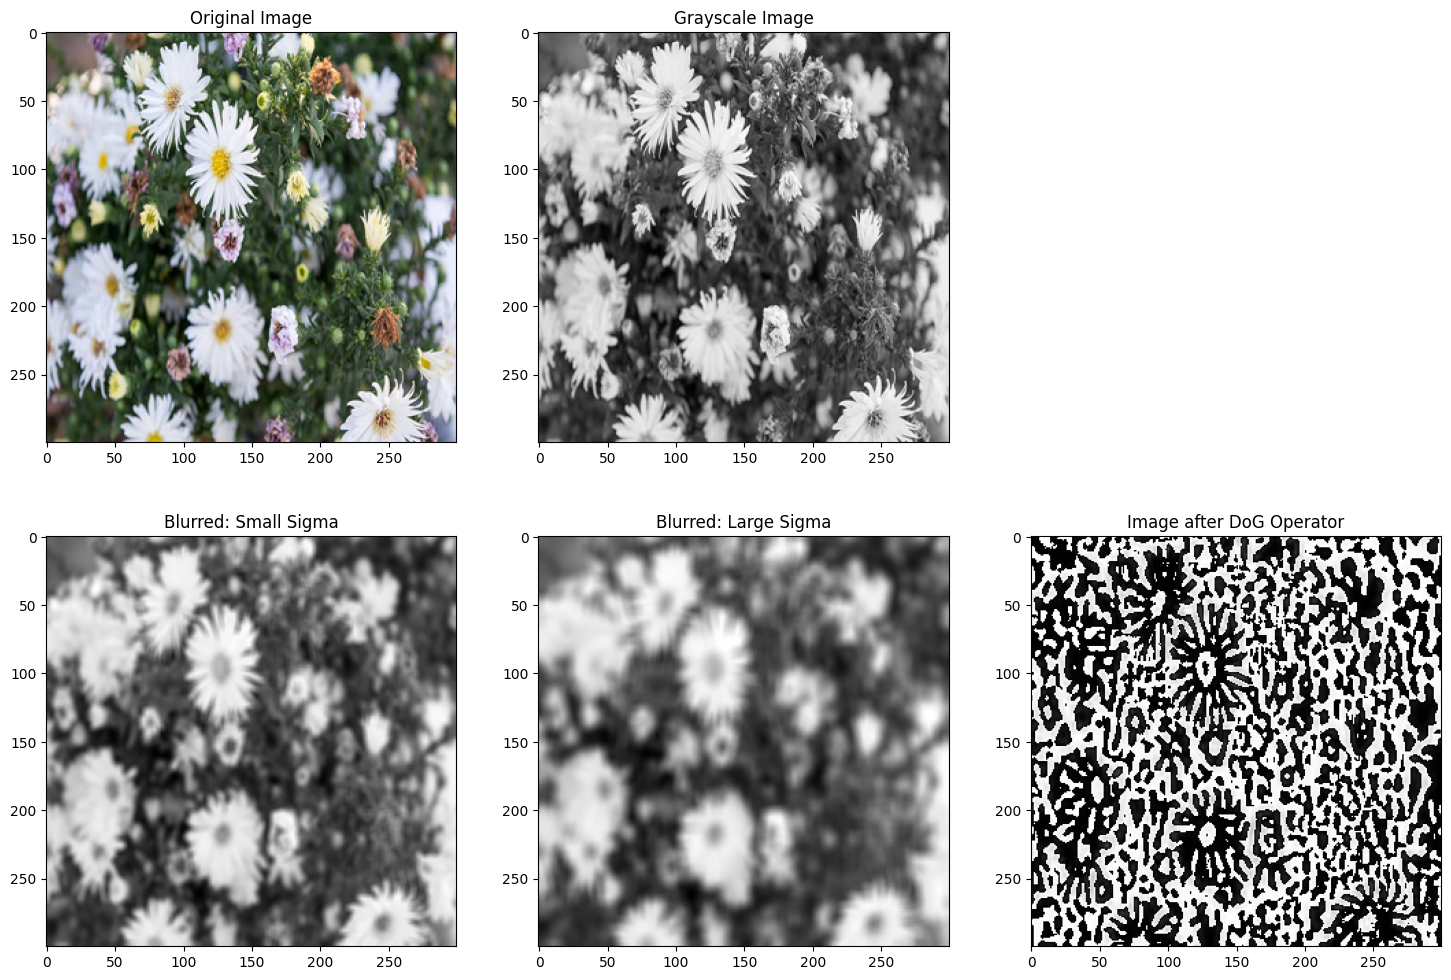

In [13]:
sigma_sm = 5
sigma_lg = 9
blurred_sm = cv2.GaussianBlur(np.array(gray), (sigma_sm, sigma_sm), sigma_sm)
blurred_lg = cv2.GaussianBlur(np.array(gray), (sigma_lg, sigma_lg), sigma_lg)

DoG = blurred_sm - blurred_lg

plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 3, 2)
plt.imshow(gray, cmap=plt.get_cmap('gray'))
plt.title("Grayscale Image")
plt.subplot(2, 3, 4)
plt.imshow(blurred_sm.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Blurred: Small Sigma")
plt.subplot(2, 3, 5)
plt.imshow(blurred_lg.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Blurred: Large Sigma")
plt.subplot(2, 3, 6)
plt.imshow(DoG.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Image after DoG Operator")
plt.show()